## Pruning Neurons in Neural Networks

Throughout the summer school, we have been discussing big neural networks models with a huge amount of parameters. The concentration of the parameters is much more in the fully connected layers and this brings us to the question whether so many parameters in the FC Layers are necessary.

<img src='images/pruning.jpg', style="width: 500px; height: 250px">

While pruning connections of the network by making the weight space sparse, we were able to drop connections. However, the model occupied the same amount of size as before in memory while doing a forward pass. Thus we would not be able to exploit that procedure to its fullest unless we write separate modules for sparse matrix multiplications in neural networks which the deep learning libraries do not provide.

In this notebook we shall see one of the solutions which remove redundant neurons from the network. Our focus shall be on fully connected layers. Through this approach we can not only reduce the size of the network on disk but the resultant model as whole will occupy less space in the RAM during a forward pass.

In [1]:
import numpy as np
np.random.seed(1337)  # for reproducibility
import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
%matplotlib inline
import matplotlib.pyplot as plt

### Hyperparameters

In [2]:
num_epochs = 5
batch_size = 100
learning_rate = 0.001
use_reg = False
alpha = 0.5
beta = 1-alpha

### Downloading MNIST

In [3]:
train_dataset = dsets.MNIST(root='../../data/lab6',
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='../../data/lab6',
                           train=False, 
                           transform=transforms.ToTensor())

Files already downloaded


### Dataloader

In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

### Defining a fully connected network to classify MNIST

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 2000)
        self.fc2 = nn.Linear(2000, 1000)
        self.fc3 = nn.Linear(1000, 10)
        
    def forward(self, x):
        out = x.view(x.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(F.relu(out))
        out = self.fc3(F.relu(out))
        return out

<b>The below function is called to reinitialize the weights of the network and define the required loss criterion and the optimizer.</b> 

In [6]:
def reset_model():
    net = Net()
    net = net.cuda()

    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    return net,criterion,optimizer

### Network Initialization

In [7]:
net, criterion, optimizer = reset_model()

### Regularizers

The goal of introducing l1 regulariser and l2 regulariser is to penalise the connections' weights between neurons to prevent overfitting. However, the application of such regularisers alone in deep neural network are not as successful as in linear regression and logistic regression. On the other hand, in the hardware computation especially using GPU, dropping connections may not save computation time and memory unless some special coding and processing is used. The introduction of dropout achieve great success to avoid over-fitting in practice with these two regularisers. These regularisation techniques are suitable for preventing overfitting but may not be helpful in simplifying the NN structure. 

Here, we see two more regularizers which help is exploring the sparsity.

$$
li\_regularizer = \lambda_{l_{i}}\sum_{l=1}^{L}\sum_{j=1}^{n_{l}}\sqrt{\sum_{i=1}^{n_{l-1}}(W_{i,j}^{l})^{2}}
$$

$$
lo\_regularizer = \lambda_{l_{i}}\sum_{l=1}^{L}\sum_{i=1}^{n_{l-1}}\sqrt{\sum_{j=1}^{n_{l}}(W_{i,j}^{l})^{2}}
$$

$$
loss = loss + \alpha*li\_regularizer + (1-\alpha)*lo\_regularizer
$$

### LI Regularizer definition

In [8]:
def li_regularizer(net):
    
    lambda_li = 0.001
    li_reg_loss = 0
    for m in net.modules():
        if isinstance(m,nn.Linear):
            temp_loss = torch.sum(((torch.sum(((m.weight)**2),1))**0.5),0)
            li_reg_loss += lambda_li*temp_loss

    return li_reg_loss


### LO Regularizer definition

In [9]:
def lo_regularizer(net):
    
    lambda_lo = 0.001
    lo_reg_loss = 0
    for m in net.modules():
        if isinstance(m,nn.Linear):
            temp_loss = torch.sum(((torch.sum(((m.weight)**2),0))**0.5),1)
            lo_reg_loss += lambda_lo*temp_loss
    
    return lo_reg_loss

### L1 Regularizer definition

In [10]:
def l1_regularizer(net, loss, beta):
    l1_crit = nn.L1Loss(size_average=False)
    reg_loss = 0
    for param in net.parameters():
        target = Variable((torch.FloatTensor(param.size()).zero_()).cuda())
        reg_loss += l1_crit(param, target)
        print(type(reg_loss))
        
    loss += beta * reg_loss
    return loss

### Training and Testing functions

In [11]:
# Train the Model

def training(net):
    
    net, criterion, optimizer = reset_model()
    
    net.train()
    for epoch in range(num_epochs):
        total_loss = 0
        accuracy = []
        for i, (images, labels) in enumerate(train_loader):
            images = images.cuda()
            labels = labels.cuda()
            temp_labels = labels
            images = Variable(images)
            labels = Variable(labels)

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            
            if use_reg == True :
        
                loss = loss + alpha*li_regularizer(net) + beta*lo_regularizer(net)
                
            loss.backward()
            optimizer.step()

            total_loss += loss.data[0]
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == temp_labels).sum()
            accuracy.append(correct/float(batch_size))

        print('Epoch: %d, Loss: %.4f, Accuracy: %.4f' %(epoch+1,total_loss, (sum(accuracy)/float(len(accuracy)))))
    
    return net

In [12]:
# Test the Model
def testing(net):
    net.eval() 
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()
        images = Variable(images)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    print('Test Accuracy of the network on the 10000 test images: %.2f %%' % (100.0 * correct / total))

In [13]:
use_reg = False
net = training(net)
testing(net)

Epoch: 1, Loss: 119.3923, Accuracy: 0.9394
Epoch: 2, Loss: 46.4104, Accuracy: 0.9766
Epoch: 3, Loss: 30.1041, Accuracy: 0.9839
Epoch: 4, Loss: 23.0836, Accuracy: 0.9874
Epoch: 5, Loss: 16.1912, Accuracy: 0.9912
Test Accuracy of the network on the 10000 test images: 97.83 %


### Visualizing the weight Space

In [14]:
def weightdistribution(weights):
    maxim= np.amax(weights)
    print("Maximum value of learnt weights: " + str(maxim))
    
    minim= np.amin(weights)
    print("Minimum value of learnt weights: " + str(minim))
    
    step= (maxim-minim)/255
    freq= np.zeros(256)
    steps=[]

    for i in range(0,256):
        steps.append(minim)
        minim+=step
    
    m = weights.shape[0]
    
    for i in range(0,m):
        e= weights[i]
        dist= (steps-e)**2
        freq[np.argmin(dist)]+=1
    
        
    plt.plot(steps,list(freq))
    plt.show()

Maximum value of learnt weights: 0.248052
Minimum value of learnt weights: -0.405209


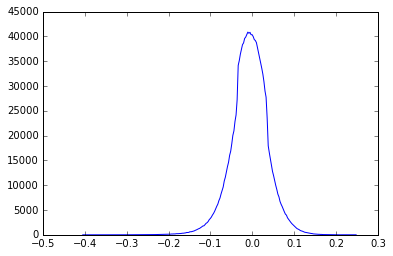

Maximum value of learnt weights: 0.316985
Minimum value of learnt weights: -0.275416


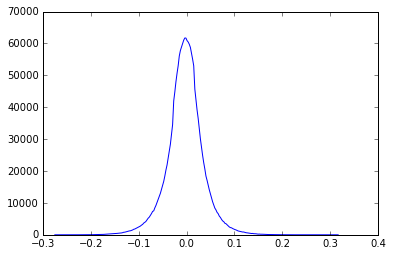

Maximum value of learnt weights: 0.135118
Minimum value of learnt weights: -0.181197


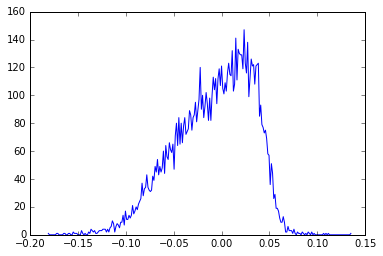

In [15]:
weightdistribution(net.state_dict()['fc1.weight'].cpu().numpy().flatten())
weightdistribution(net.state_dict()['fc2.weight'].cpu().numpy().flatten())
weightdistribution(net.state_dict()['fc3.weight'].cpu().numpy().flatten())

### Training with the defined regularizers

Next we train with the li and lo regularizers defined previously. We hope to address the issue of overfitting to some extent by using these regularizers. Also, the weight matrices are plotted to observe the distribution. 

In [16]:
use_reg = True
net = training(net)
testing(net)

Epoch: 1, Loss: 523.9746, Accuracy: 0.9187
Epoch: 2, Loss: 276.9573, Accuracy: 0.9569
Epoch: 3, Loss: 231.0317, Accuracy: 0.9657
Epoch: 4, Loss: 209.9979, Accuracy: 0.9701
Epoch: 5, Loss: 194.6021, Accuracy: 0.9722
Test Accuracy of the network on the 10000 test images: 97.17 %


Maximum value of learnt weights: 0.205296
Minimum value of learnt weights: -0.393424


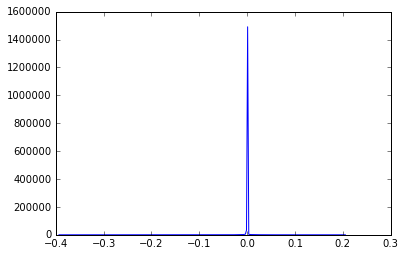

Maximum value of learnt weights: 0.361336
Minimum value of learnt weights: -0.285791


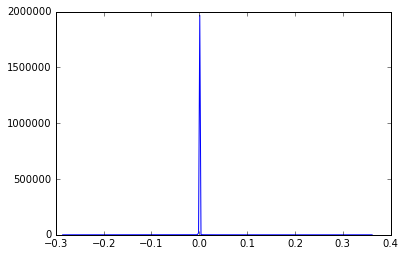

Maximum value of learnt weights: 0.53231
Minimum value of learnt weights: -0.482011


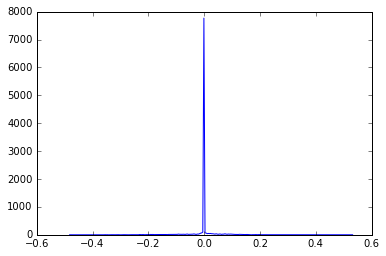

In [17]:
weightdistribution(net.state_dict()['fc1.weight'].cpu().numpy().flatten())
weightdistribution(net.state_dict()['fc2.weight'].cpu().numpy().flatten())
weightdistribution(net.state_dict()['fc3.weight'].cpu().numpy().flatten())

### Pruning

We next prune the parameters based ona threshold criterion as seen previously. The parameters before and after pruning are printed below.

In [18]:
threshold = 0.01

for m in net.modules():
    if isinstance(m,nn.Conv2d) or isinstance(m,nn.BatchNorm2d) or isinstance(m,nn.Linear):
        
        temp_weight = m.weight.data.cpu().numpy()
        dims = temp_weight.shape
        print('WEIGHT ',dims)
        print("Before pruning------->")
        print(np.count_nonzero(temp_weight))
        
        temp_weight = temp_weight.flatten()
        
        [x1,x2]=((np.where(np.all([[(-1*threshold) < (temp_weight)] , [(temp_weight) < threshold]],axis=0))))
        temp_weight[x2] = 0
        temp_weight = np.reshape(temp_weight,dims)
        print("After pruning------->")
        print(np.count_nonzero(temp_weight))
        print('-------------------------------------------------------------------------------')
        m.weight.data = (torch.FloatTensor(temp_weight).cuda())

('WEIGHT ', (2000, 784))
Before pruning------->
1566392
After pruning------->
25700
-------------------------------------------------------------------------------
('WEIGHT ', (1000, 2000))
Before pruning------->
1998947
After pruning------->
11043
-------------------------------------------------------------------------------
('WEIGHT ', (10, 1000))
Before pruning------->
9964
After pruning------->
1932
-------------------------------------------------------------------------------


### Removing all zero rows and columns

1. We remove those columns in the weight matrices which have all the values as zero.
2. In the weight matrix for the next layer, we need to remove the corresponding rows.
3. We must eventually end up removing the intersection of the two.

<img src='images/drop_neuron.png'>

In [19]:
fc1_weight = net.fc1.weight.data.cpu().numpy()
fc2_weight = net.fc2.weight.data.cpu().numpy()
fc3_weight = net.fc3.weight.data.cpu().numpy()

print('---------------------------Original dimensions-----------------------')
print(fc1_weight.shape)
print(fc2_weight.shape)
print(fc3_weight.shape)
print('---------------------------Final dimensions-----------------------')

fc1_row_zero = np.where(~fc1_weight.any(axis=1))[0]
fc2_col_zero = np.where(~fc2_weight.any(axis=0))[0]
indices = set(fc1_row_zero).intersection(fc2_col_zero)
indices = list(indices)

fc1_weight = np.delete(fc1_weight,indices,axis=0)
fc2_weight = np.delete(fc2_weight,indices,axis=1)


fc2_row_zero = np.where(~fc2_weight.any(axis=1))[0]
fc3_col_zero = np.where(~fc3_weight.any(axis=0))[0]
indices = set(fc2_row_zero).intersection(fc3_col_zero)
indices = list(indices)

fc2_weight = np.delete(fc2_weight,indices,axis=0)
fc3_weight = np.delete(fc3_weight,indices,axis=1)

print(fc1_weight.shape)
print(fc2_weight.shape)
print(fc3_weight.shape)

---------------------------Original dimensions-----------------------
(2000, 784)
(1000, 2000)
(10, 1000)
---------------------------Final dimensions-----------------------
(111, 784)
(235, 111)
(10, 235)


### Define a Modified Network

After removing entire rows and columns of the bigger weight matrices we are left with smaller number of parameters which we can use to initialize a smaller network. In order to do that, first we need to define one.

We define a modified network by using the dimensions of the modified weight matrix which we received in our previous step. Then, we reset that model too.

In [20]:
class Mod_Net(nn.Module):
    def __init__(self):
        super(Mod_Net, self).__init__()
        self.fc1 = nn.Linear(fc1_weight.shape[1], fc1_weight.shape[0])
        self.fc2 = nn.Linear(fc2_weight.shape[1], fc2_weight.shape[0])
        self.fc3 = nn.Linear(fc3_weight.shape[1], fc3_weight.shape[0])
        
    def forward(self, x):
        out = x.view(x.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(F.relu(out))
        out = self.fc3(F.relu(out))
        return out

In [21]:
def reset_mod_model():
    modnet = Mod_Net()
    modnet = modnet.cuda()

    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(modnet.parameters(), lr=learning_rate)
    return modnet,criterion,optimizer

In [22]:
modnet, criterion, optimizer = reset_mod_model()

Here we initialize the smaller model with the smaller weight matrices. 

In [23]:
modnet.fc1.weight.data = (torch.FloatTensor(fc1_weight).cuda())
modnet.fc2.weight.data = (torch.FloatTensor(fc2_weight).cuda())
modnet.fc3.weight.data = (torch.FloatTensor(fc3_weight).cuda())

In [24]:
testing(modnet)

Test Accuracy of the network on the 10000 test images: 97.19 %


### Excercise

1. Retrain the smaller model and check if the performance improves.

2. Using the l1 regularizer along with lo and li with further enhance sparsity. This might result in a even smaller model. Try it out!!

### References

1. https://arxiv.org/pdf/1606.07326.pdf